<a href="https://colab.research.google.com/github/imaboylol/itmo-advanced-ml-and-dl/blob/main/classification-svm/SVM_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

In [54]:
df = pd.read_csv('persons_pics_train.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,0.237908,0.273203,0.244444,0.332026,0.590850,0.675817,0.684967,0.733333,0.771242,0.771242,...,0.686275,0.694118,0.720261,0.746405,0.756863,0.735948,0.715033,0.684967,0.657516,Tony Blair
1322,0.105882,0.087582,0.117647,0.260131,0.385621,0.466667,0.566013,0.657516,0.692810,0.691503,...,0.722876,0.376471,0.188235,0.139869,0.188235,0.226144,0.243137,0.248366,0.244444,Gerhard Schroeder
1323,0.322876,0.345098,0.369935,0.375163,0.405229,0.464052,0.494118,0.511111,0.517647,0.495425,...,0.465359,0.486274,0.505882,0.535948,0.550327,0.551634,0.552941,0.554248,0.563399,George W Bush
1324,0.304575,0.290196,0.366013,0.444444,0.456209,0.465359,0.479739,0.532026,0.585621,0.603922,...,0.513725,0.802614,0.942484,0.933333,0.707190,0.223529,0.124183,0.133333,0.113725,George W Bush


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [55]:
def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

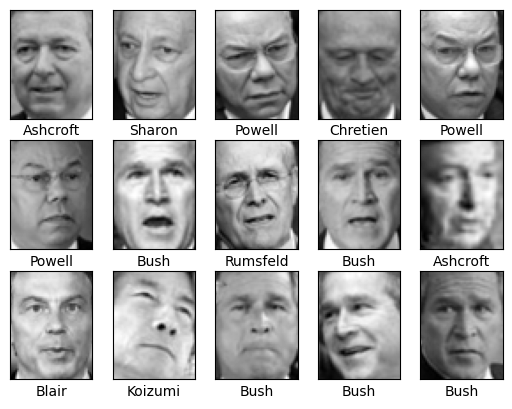

In [56]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

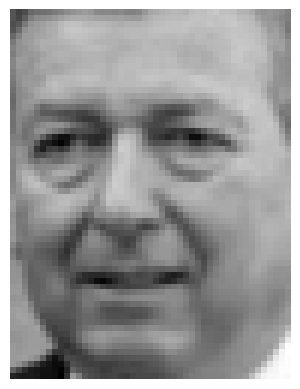

In [57]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [58]:
# < ENTER YOUR CODE HERE >
labels = df['label'].value_counts()
labels

,count
label,
George W Bush,451
Colin Powell,201
Tony Blair,122
Donald Rumsfeld,103
Gerhard Schroeder,93
Ariel Sharon,65
Hugo Chavez,60
Junichiro Koizumi,51
Jean Chretien,47


Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

In [ ]:
# < ENTER YOUR CODE HERE >

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [59]:
# < ENTER YOUR CODE HERE >
# Создаем словарь для хранения усредненных векторов
average_vectors = {}

# Находим уникальные метки людей
unique_labels = df['label'].unique()

# Создаем усредненный вектор для каждого человека
for label in unique_labels:
    # Отбираем строки, соответствующие текущему человеку
    person_images = df[df['label'] == label]
    # Вычисляем среднее по каждому пикселю
    mean_vector = person_images.iloc[:, :-1].mean(axis=0)
    # Сохраняем усредненный вектор в словаре
    average_vectors[label] = mean_vector

average_vectors

{'John Ashcroft': 0       0.337894
 1       0.334379
 2       0.337662
 3       0.357037
 4       0.384779
           ...   
 2909    0.540944
 2910    0.534524
 2911    0.524415
 2912    0.527495
 2913    0.527495
 Length: 2914, dtype: float64,
 'Ariel Sharon': 0       0.501398
 1       0.514811
 2       0.532609
 3       0.551714
 4       0.569754
           ...   
 2909    0.515656
 2910    0.498220
 2911    0.486657
 2912    0.466928
 2913    0.437687
 Length: 2914, dtype: float64,
 'Colin Powell': 0       0.433512
 1       0.441147
 2       0.456248
 3       0.471947
 4       0.486730
           ...   
 2909    0.510006
 2910    0.477586
 2911    0.448119
 2912    0.410659
 2913    0.379605
 Length: 2914, dtype: float64,
 'Jean Chretien': 0       0.388958
 1       0.412488
 2       0.446614
 3       0.487637
 4       0.526158
           ...   
 2909    0.455180
 2910    0.426060
 2911    0.415353
 2912    0.414713
 2913    0.397608
 Length: 2914, dtype: float64,
 'George W Bush': 

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [60]:
# < ENTER YOUR CODE HERE >
bush_images = df[df['label'] == 'George W Bush']

# Считаем средние значения по каждому пикселю (каждой колонке)
mean_vector = bush_images.iloc[:, :-1].mean(axis=0)

# Извлекаем значение первой координаты (пикселя с индексом 0)
coord_index_0 = mean_vector[0]
coord_index_0

<ipython-input-60-436d3bf0213c>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord_index_0 = mean_vector[0]


0.3481790740804878

Используя усредненные векторы, постройте изображения всех людей из набора данных.

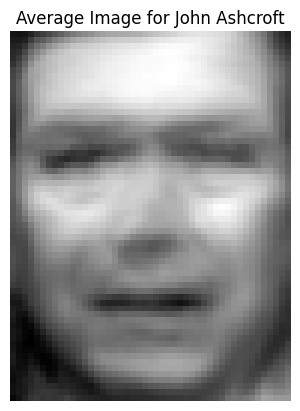

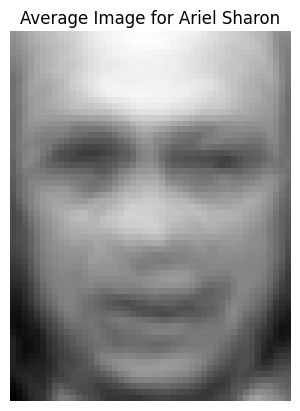

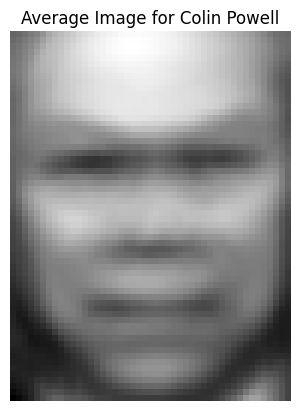

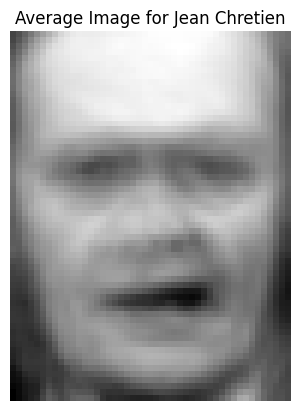

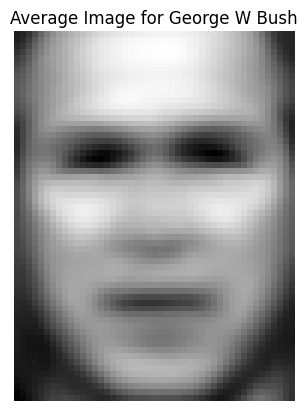

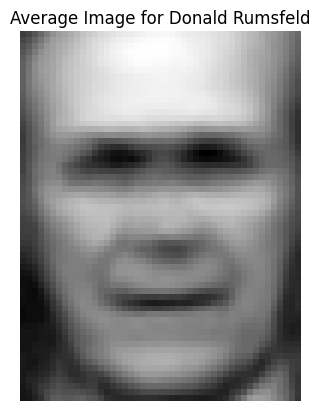

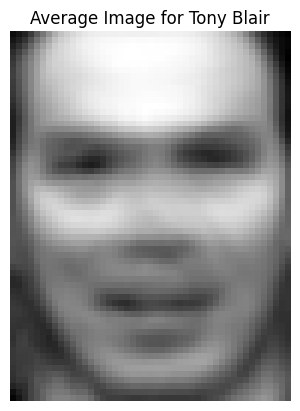

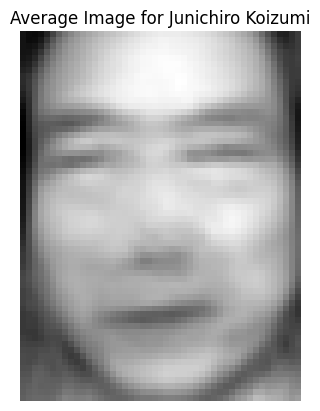

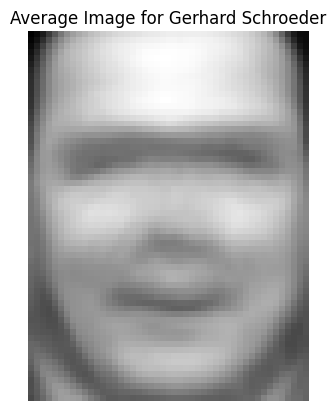

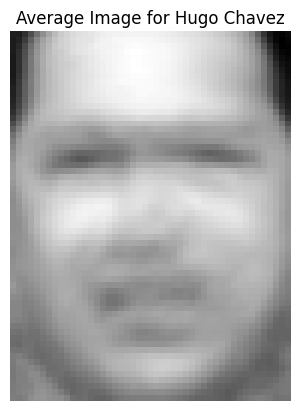

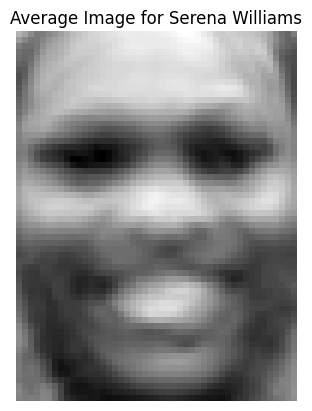

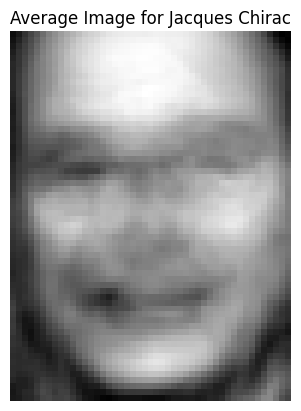

In [61]:
# < ENTER YOUR CODE HERE >
# Визуализируем изображения усредненных векторов для каждого человека
for label, vector in average_vectors.items():
    # Преобразуем вектор длиной 2914 в изображение 62x47
    image = vector.values.reshape(62, 47)

    # Отображаем изображение
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f'Average Image for {label}')
    plt.axis('off')
    plt.show()

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [62]:
# < ENTER YOUR CODE HERE >
# Предполагаем, что `average_vectors` - словарь с именами людей и их усредненными векторами,
# полученный на предыдущем шаге.

# Преобразуем словарь в DataFrame для удобства
average_vectors_df = pd.DataFrame(average_vectors).T
average_vectors_df = average_vectors_df.dropna()

# Вычисляем матрицу косинусного сходства
similarity_matrix = cosine_similarity(average_vectors_df)

# Преобразуем матрицу сходства в DataFrame для удобства доступа к парам
similarity_df = pd.DataFrame(similarity_matrix, index=average_vectors_df.index, columns=average_vectors_df.index)

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [63]:
# < ENTER YOUR CODE HERE >
similarity_ariel_tony = similarity_df.loc['Ariel Sharon', 'Tony Blair']
similarity_ariel_tony

0.9953621581827831

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [64]:
# < ENTER YOUR CODE HERE >
X = df.iloc[:, :-1]  # пиксели
y = df['label']      # метки классов

# стратификация по label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [65]:
# < ENTER YOUR CODE HERE >
model = SVC(kernel='linear', random_state=17)
model.fit(X_train, y_train)

# Предсказываем метки для тестовой выборки
y_pred = model.predict(X_test)

# Вычисляем f1_score с 'weighted' усреднением
f1 = f1_score(y_test, y_pred, average='weighted')

f1

0.7782703951044567

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [66]:
# < ENTER YOUR CODE HERE >
tuned_parameters = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1e-3, 1e-4],
    'C': [1, 10, 100, 1000],
    'class_weight': [None, 'balanced'],
    'random_state': [17]
}]

# Создаем объект GridSearchCV с кросс-валидацией
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

# Выполняем поиск по сетке на обучающих данных
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.783 total time=   0.6s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.750 total time=   0.6s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.802 total time=   0.6s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.783 total time=   0.6s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.797 total time=   0.6s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=17;, score=0.382 total time=   0.7s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=17;, score=0.363 total time=   0.7s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=17;, score=0.358 total time=   0.7s
[CV 4/5] END C=1, class_weight=N

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [17]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [67]:
# < ENTER YOUR CODE HERE >
best_params = cv.best_params_
best_score = cv.best_score_

best_params, best_score

({'C': 1000,
  'class_weight': 'balanced',
  'gamma': 0.0001,
  'kernel': 'rbf',
  'random_state': 17},
 0.7952830188679245)

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [68]:
# < ENTER YOUR CODE HERE >
y_pred = cv.predict(X_test)

# Вычисляем f1_score с 'weighted' усреднением
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.7707024364516625

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [ ]:
# < ENTER YOUR CODE HERE >

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [70]:
# < ENTER YOUR CODE HERE >
# Создаем и обучаем модель PCA на тренировочных данных
pca = PCA(svd_solver='full')
pca.fit(X_train)

# Вычисляем кумулятивную сумму объясненной дисперсии
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Определяем минимальное количество компонент, при котором объясненная дисперсия больше 0.95
n_components = next(i for i, total_variance in enumerate(cumulative_variance) if total_variance > 0.95) + 1

n_components

172

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [72]:
# < ENTER YOUR CODE HERE >
pca = PCA(n_components=n_components, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Задаем параметры для поиска
tuned_parameters = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1e-3, 1e-4],
    'C': [1, 10, 100, 1000],
    'class_weight': [None, 'balanced'],
    'random_state': [17]
}]

# Настраиваем и выполняем GridSearchCV
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

cv.fit(X_train_pca, y_train)

# Получаем лучшие параметры и время обучения
best_params = cv.best_params_
best_params

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.807 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.722 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.802 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.788 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=17;, score=0.802 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=17;, score=0.340 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=17;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=17;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=N

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 17}

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE >

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [73]:
# < ENTER YOUR CODE HERE >
y_pred = cv.predict(X_test_pca)

# Вычисляем f1_score с 'weighted' усреднением
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.7722381110774165

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

# Предсказание зарезервированной части датасета

In [74]:
df_test = pd.read_csv('persons_pics_reserved.csv')
df_test

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,0.315033,0.393464,0.517647,0.636601,0.652288,0.653595,0.677124,0.725490,0.716340,0.695425,...,0.031373,0.047059,0.047059,0.053595,0.050980,0.036601,0.027451,0.011765,0.007843,0.003922
1,0.518954,0.664052,0.690196,0.627451,0.576471,0.575163,0.605229,0.633987,0.666667,0.684967,...,0.568627,0.583007,0.577778,0.549020,0.479739,0.403922,0.427451,0.569935,0.772549,0.924183
2,0.196078,0.205229,0.219608,0.197386,0.179085,0.223529,0.295425,0.363399,0.411765,0.471895,...,0.471895,0.479739,0.486274,0.511111,0.528105,0.556863,0.586928,0.611765,0.610458,0.627451
3,0.330719,0.376471,0.413072,0.420915,0.430065,0.454902,0.477124,0.486274,0.487582,0.494118,...,0.688889,0.715033,0.724183,0.695425,0.308497,0.126797,0.125490,0.125490,0.111111,0.109804
4,0.405229,0.428758,0.487582,0.567320,0.619608,0.648366,0.665359,0.686275,0.701961,0.717647,...,0.611765,0.630065,0.627451,0.746405,0.700654,0.200000,0.099346,0.095425,0.087582,0.083660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.435294,0.490196,0.541176,0.601307,0.631373,0.647059,0.681046,0.692810,0.696732,0.720261,...,0.588235,0.586928,0.606536,0.600000,0.654902,0.769935,0.909804,0.986928,0.994771,0.990850
230,0.478431,0.558170,0.601307,0.618301,0.637908,0.649673,0.653595,0.640523,0.630065,0.615686,...,0.128105,0.064052,0.079739,0.091503,0.077124,0.077124,0.074510,0.074510,0.082353,0.086275
231,0.483660,0.474510,0.494118,0.512418,0.529412,0.555556,0.590850,0.626144,0.641830,0.662745,...,0.573856,0.624837,0.707190,0.811765,0.933333,0.985621,0.981699,0.985621,0.989542,0.983007
232,0.284967,0.453595,0.415686,0.384314,0.341176,0.354248,0.407843,0.397386,0.330719,0.324183,...,0.292810,0.301961,0.315033,0.301961,0.390850,0.639216,0.835294,0.904575,0.933333,0.938562


(-0.5, 46.5, 61.5, -0.5)

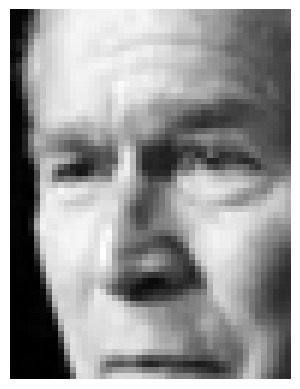

In [91]:
plt.imshow(df_test.iloc[205].astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')